### Rutinas Preliminares y Detalles de Ejecución

In [1]:
# LIBRERIAS NECESARIAS 
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import pyodbc
from dotenv import dotenv_values
import psycopg2 as pg2    # Conectores para Postgres
import getpass  # Para obtener el usuario del sistema operativo

# Mostrar el DataFrame resultante
import ace_tools_open as tools

import uuid  # Importar la librería uuid

# Evitar Mensajes Molestos
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category= FutureWarning)

secrets = dotenv_values(".env")   # Connection String from .env
folder = secrets["FOLDER_DATOS"]

import matplotlib.pyplot as plt

In [2]:
id_proveedor = '189'
name= '189_BODEGAS_LOPEZ'
forecast_execution_id ='28698426-7037-461b-b1e9-c2ba21031b6a'
forecast_execution_excecute_id ='ed7848d3-5dcb-41d2-9c36-0c4bdc468fbc'
supplier_id = '8e6e66f7-2482-451b-a656-5a1999343186'
algoritmo = '189_BODEGAS_LOPEZ_ALGO_05'

In [6]:
id_proveedor = '62'
name= '62_ARCOR'
forecast_execution_id ='c1cb2d47-d93f-4892-8aa9-1a8b790fcfe3'
forecast_execution_excecute_id ='46a3b044-ce8a-490b-a57c-5639f909a9dd'
supplier_id = 'f006a0c2-6da6-46d6-b014-a6de03cd522c'
algoritmo = '62_ARCOR_ALGO_05'

In [3]:


# Recuperar Historial de Ventas
df_ventas = pd.read_csv(f'{folder}/{name}_Ventas.csv')
df_ventas['Codigo_Articulo']= df_ventas['Codigo_Articulo'].astype(int)
df_ventas['Sucursal']= df_ventas['Sucursal'].astype(int)
df_ventas['Fecha']= pd.to_datetime(df_ventas['Fecha'])

# Recuperar Maestro de Artículos
articulos = pd.read_csv(f'{folder}/{name}_Articulos.csv')
articulos.head()

# Recuperar Maestro de Artículos
#df_validacion = pd.read_csv(f'{folder}/{algoritmo}_Datos_Validacion.csv')
#articulos.head()

# Recuperando Forecast Calculado
df_forecast = pd.read_csv(f'{folder}/{algoritmo}_Solicitudes_Compra.csv')
df_forecast.fillna(0)   # Por si se filtró algún missing value
print(f"-> Datos Recuperados del CACHE: {id_proveedor}, Label: {name}")


-> Datos Recuperados del CACHE: 189, Label: 189_BODEGAS_LOPEZ


In [ ]:
df_forecast['GRAFICO'] = None

In [4]:
df_ventas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16593 entries, 0 to 16592
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Fecha            16593 non-null  datetime64[ns]
 1   Codigo_Articulo  16593 non-null  int64         
 2   Sucursal         16593 non-null  int64         
 3   Unidades         16593 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(2)
memory usage: 518.7 KB


In [5]:
# Filtrar df_ventas para conservar solo los últimos 45 días
fecha_maxima = df_ventas["Fecha"].max()


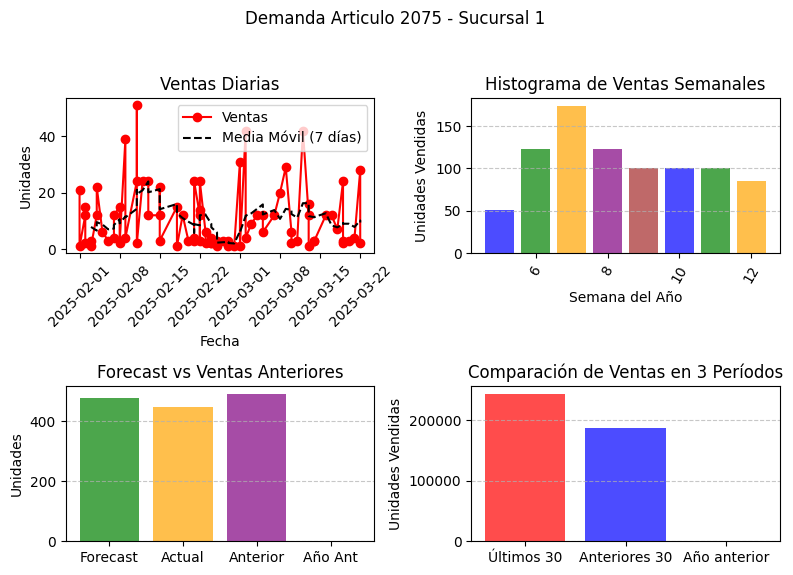

In [10]:
# DEFINIR EL GRAFICO EJEMPLO
articulo = 2075
sucursal = 1

dfv_fil = df_ventas[(df_ventas["Codigo_Articulo"] == articulo) & (df_ventas["Sucursal"] == sucursal)]
dfv_fil = dfv_fil[dfv_fil["Fecha"] >= (fecha_maxima - pd.Timedelta(days=50))]

fig, ax = plt.subplots(
    figsize=(8, 6), nrows= 2, ncols= 2
)
fig.suptitle(f"Demanda Articulo {articulo} - Sucursal {sucursal}")
current_ax = 0
#Bucle para Llenar los gráficos
colors =["red", "blue", "green", "orange", "purple", "brown", "pink", "gray", "olive", "cyan"]

# Ventas Diarias
dfv_fil["Media_Movil"] = dfv_fil["Unidades"].rolling(window=7).mean()

# Ventas Diarias
ax[0, 0].plot(dfv_fil["Fecha"], dfv_fil["Unidades"], marker="o", linestyle="-", label="Ventas", color=colors[0])
ax[0, 0].plot(dfv_fil["Fecha"], dfv_fil["Media_Movil"], linestyle="--", label="Media Móvil (7 días)", color="black")
ax[0, 0].set_title("Ventas Diarias")
ax[0, 0].legend()
ax[0, 0].set_xlabel("Fecha")
ax[0, 0].set_ylabel("Unidades")
ax[0, 0].tick_params(axis='x', rotation=45)

# Ventas Semanales
dfv_fil["Semana"] = dfv_fil["Fecha"].dt.to_period("W").astype(str)
df_semanal = dfv_fil.groupby("Semana")["Unidades"].sum().reset_index()
df_semanal["Semana_Num"] = dfv_fil.groupby("Semana")["Fecha"].min().reset_index()["Fecha"].dt.isocalendar().week.astype(int)
df_semanal["Media_Movil"] = df_semanal["Unidades"].rolling(window=7).mean()

# Histograma de ventas semanales
ax[0, 1].bar(df_semanal["Semana_Num"], df_semanal["Unidades"], color=[colors[1],colors[2], colors[3], colors[4], colors[5]], alpha=0.7)
ax[0, 1].set_xlabel("Semana del Año")
ax[0, 1].set_ylabel("Unidades Vendidas")
ax[0, 1].set_title("Histograma de Ventas Semanales")
ax[0, 1].tick_params(axis='x', rotation=60)
ax[0, 1].grid(axis="y", linestyle="--", alpha=0.7)

# Graficar el Forecast vs Ventas Reales en la tercera celda
df_forecast_f = df_forecast[(df_forecast["Codigo_Articulo"] == articulo) & (df_forecast["Sucursal"] == sucursal)]
labels = ["Forecast","Actual", "Anterior", "Año Ant"]
values = [df_forecast_f["Forecast"].iloc[0], df_forecast_f["ventas_last"].iloc[0], df_forecast_f["ventas_previous"].iloc[0], df_forecast_f["ventas_same_year"].iloc[0]]

ax[1, 0].bar(labels, values, color=[colors[2], colors[3], colors[4], colors[5]], alpha=0.7)
ax[1, 0].set_title("Forecast vs Ventas Anteriores")
ax[1, 0].set_ylabel("Unidades")
ax[1, 0].grid(axis="y", linestyle="--", alpha=0.7)

# Definir fechas de referencia
fecha_maxima = df_ventas["Fecha"].max()
fecha_inicio_ultimos30 = fecha_maxima - pd.Timedelta(days=30)
fecha_inicio_previos30 = fecha_inicio_ultimos30 - pd.Timedelta(days=30)
fecha_inicio_anio_anterior = fecha_inicio_ultimos30 - pd.DateOffset(years=1)
fecha_fin_anio_anterior = fecha_inicio_previos30 - pd.DateOffset(years=1)

# Calcular ventas de los últimos períodos de 30 días
ventas_ultimos_30 = df_ventas[(df_ventas["Fecha"] > fecha_inicio_ultimos30)]["Unidades"].sum()
ventas_previos_30 = df_ventas[
    (df_ventas["Fecha"] > fecha_inicio_previos30) & (df_ventas["Fecha"] <= fecha_inicio_ultimos30)
]["Unidades"].sum()

# Simulación de datos para las ventas del año anterior
df_filtrado_anio_anterior = df_ventas.copy()
df_filtrado_anio_anterior["Fecha"] = df_filtrado_anio_anterior["Fecha"] - pd.DateOffset(years=1)

ventas_mismo_periodo_anio_anterior = df_filtrado_anio_anterior[
    (df_filtrado_anio_anterior["Fecha"] > fecha_inicio_anio_anterior) &
    (df_filtrado_anio_anterior["Fecha"] <= fecha_fin_anio_anterior)
]["Unidades"].sum()

# Datos para el histograma
labels = ["Últimos 30", "Anteriores 30", "Año anterior"]
values = [ventas_ultimos_30, ventas_previos_30, ventas_mismo_periodo_anio_anterior]

# Graficar el histograma en la celda [1,1]
ax[1, 1].bar(labels, values, color=[colors[0], colors[1], colors[2]], alpha=0.7)
ax[1, 1].set_title("Comparación de Ventas en 3 Períodos")
ax[1, 1].set_ylabel("Unidades Vendidas")
ax[1, 1].grid(axis="y", linestyle="--", alpha=0.7)

# Mostrar el gráfico
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajustar para no solapar con el título
plt.show()



#### Revisar un Gráfico al Azar

In [ ]:
import matplotlib.pyplot as plt
import base64
from io import BytesIO
from IPython.display import display, Image

# Función para decodificar y mostrar una imagen en Jupyter Notebook
def mostrar_grafico_base64(base64_string):
    if base64_string is None:
        print("No hay gráfico disponible.")
        return
    
    img_data = base64.b64decode(base64_string)
    buffer = BytesIO(img_data)
    
    # Mostrar la imagen en Jupyter Notebook
    display(Image(buffer.getvalue()))

# Seleccionar un gráfico aleatorio para visualizar
fila_ejemplo = df_forecast.dropna(subset=["GRAFICO"]).sample(2).iloc[0]
mostrar_grafico_base64(fila_ejemplo["GRAFICO"])


In [ ]:
# Mostrar el DataFrame actualizado
import ace_tools_open as tools
tools.display_dataframe_to_user(name="Forecast Execution Status Updated", dataframe=fe)

# GUARDAR ARCHIVO con GRAFICOS y Datos Extendidos.
df_merged.to_csv(f'{folder}/{algoritmo}_Pronostico_Extendido.csv', index=False)

### RUTINA GENERADORA DE GRÁFICOS

1) Leer archivo Solicitudes_Compra
2) Leer datos adicionales y id relacionados
3) Leer datos adicionales de la T710_Estadis_Reposición
4) Generar GRAFICOS
5) Subir Información a connexa

In [ ]:
# RUTINA GENERADORA GLOBAL DE GRÄRICOS
import base64
from io import BytesIO
import pandas as pd
import matplotlib.pyplot as plt
# LIBRERIAS NECESARIAS 
from datetime import datetime, timedelta
import numpy as np
import pyodbc
from dotenv import dotenv_values
import psycopg2 as pg2    # Conectores para Postgres
import getpass  # Para obtener el usuario del sistema operativo
import uuid  # Importar la librería uuid
# Mostrar el DataFrame resultante
import ace_tools_open as tools

# Evitar Mensajes Molestos
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category= FutureWarning)

secrets = dotenv_values(".env")   # Connection String from .env
folder = secrets["FOLDER_DATOS"]


def generar_grafico_base64(dfv, articulo, sucursal, Forecast, Average, ventas_last, ventas_previous, ventas_same_year):
    fecha_maxima = dfv["Fecha"].max()
    df_filtrado = dfv[(dfv["Codigo_Articulo"] == articulo) & (dfv["Sucursal"] == sucursal)]
    df_filtrado = df_filtrado[df_filtrado["Fecha"] >= (fecha_maxima - pd.Timedelta(days=50))]

    fig, ax = plt.subplots(
        figsize=(8, 6), nrows= 2, ncols= 2
    )
    fig.suptitle(f"Demanda Articulo {articulo} - Sucursal {sucursal}")
    current_ax = 0
    #Bucle para Llenar los gráficos
    colors =["red", "blue", "green", "orange", "purple", "brown", "pink", "gray", "olive", "cyan"]

    # Ventas Diarias
    df_filtrado["Media_Movil"] = df_filtrado["Unidades"].rolling(window=7).mean()

    # Ventas Diarias
    ax[0, 0].plot(df_filtrado["Fecha"], df_filtrado["Unidades"], marker="o", linestyle="-", label="Ventas", color=colors[0])
    ax[0, 0].plot(df_filtrado["Fecha"], df_filtrado["Media_Movil"], linestyle="--", label="Media Móvil (7 días)", color="black")
    ax[0, 0].set_title("Ventas Diarias")
    ax[0, 0].legend()
    ax[0, 0].set_xlabel("Fecha")
    ax[0, 0].set_ylabel("Unidades")
    ax[0, 0].tick_params(axis='x', rotation=45)

    # Ventas Semanales
    df_filtrado["Semana"] = df_filtrado["Fecha"].dt.to_period("W").astype(str)
    df_semanal = df_filtrado.groupby("Semana")["Unidades"].sum().reset_index()
    df_semanal["Semana_Num"] = df_filtrado.groupby("Semana")["Fecha"].min().reset_index()["Fecha"].dt.isocalendar().week.astype(int)
    df_semanal["Media_Movil"] = df_semanal["Unidades"].rolling(window=7).mean()

    # Histograma de ventas semanales
    ax[0, 1].bar(df_semanal["Semana_Num"], df_semanal["Unidades"], color=[colors[1],colors[2], colors[3], colors[4], colors[5]], alpha=0.7)
    ax[0, 1].set_xlabel("Semana del Año")
    ax[0, 1].set_ylabel("Unidades Vendidas")
    ax[0, 1].set_title("Histograma de Ventas Semanales")
    ax[0, 1].tick_params(axis='x', rotation=60)
    ax[0, 1].grid(axis="y", linestyle="--", alpha=0.7)

    # Graficar el Forecast vs Ventas Reales en la tercera celda
    labels = ["Forecast","Actual", "Anterior", "Año Ant"]
    values = [Forecast, ventas_last, ventas_previous, ventas_same_year]

    ax[1, 0].bar(labels, values, color=[colors[2], colors[3], colors[4], colors[5]], alpha=0.7)
    ax[1, 0].set_title("Forecast vs Ventas Anteriores")
    ax[1, 0].set_ylabel("Unidades")
    ax[1, 0].grid(axis="y", linestyle="--", alpha=0.7)

    # Definir fechas de referencia
    fecha_maxima = df_filtrado["Fecha"].max()
    fecha_inicio_ultimos30 = fecha_maxima - pd.Timedelta(days=30)
    fecha_inicio_previos30 = fecha_inicio_ultimos30 - pd.Timedelta(days=30)
    fecha_inicio_anio_anterior = fecha_inicio_ultimos30 - pd.DateOffset(years=1)
    fecha_fin_anio_anterior = fecha_inicio_previos30 - pd.DateOffset(years=1)

    # Calcular ventas de los últimos 30 días
    ventas_ultimos_30 = df_filtrado[(df_filtrado["Fecha"] > fecha_inicio_ultimos30)]["Unidades"].sum()

    # Calcular ventas de los 30 días previos a los últimos 30 días
    ventas_previos_30 = df_filtrado[
        (df_filtrado["Fecha"] > fecha_inicio_previos30) & (df_filtrado["Fecha"] <= fecha_inicio_ultimos30)
    ]["Unidades"].sum()

    # Simulación de datos para las ventas del año anterior
    df_filtrado_anio_anterior = df_filtrado.copy()
    df_filtrado_anio_anterior["Fecha"] = df_filtrado_anio_anterior["Fecha"] - pd.DateOffset(years=1)
    ventas_mismo_periodo_anio_anterior = df_filtrado_anio_anterior[
        (df_filtrado_anio_anterior["Fecha"] > fecha_inicio_anio_anterior) &
        (df_filtrado_anio_anterior["Fecha"] <= fecha_fin_anio_anterior)
    ]["Unidades"].sum()

    # Datos para el histograma
    labels = ["Últimos 30", "Anteriores 30", "Año anterior", "Average"]
    values = [ventas_ultimos_30, ventas_previos_30, ventas_mismo_periodo_anio_anterior, Average]

    # Graficar el histograma en la celda [1,1]
    ax[1, 1].bar(labels, values, color=[colors[0], colors[1], colors[2]], alpha=0.7)
    ax[1, 1].set_title("Comparación de Ventas en 3 Períodos")
    ax[1, 1].set_ylabel("Unidades Vendidas")
    ax[1, 1].grid(axis="y", linestyle="--", alpha=0.7)

    # Mostrar el gráfico
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Ajustar para no solapar con el título

    # Guardar gráfico en base64
    buffer = BytesIO()
    plt.savefig(buffer, format="png")
    plt.close()
    
    return base64.b64encode(buffer.getvalue()).decode("utf-8")


In [ ]:
# Funciones de conexión a la base de datos
def Open_Conn_Postgres():
    secrets = dotenv_values(".env")   # Cargar credenciales desde .env    
    conn_str = f"dbname={secrets['BASE4']} user={secrets['USUARIO4']} password={secrets['CONTRASENA4']} host={secrets['SERVIDOR4']} port={secrets['PUERTO4']}"
    try:    
        conn = pg2.connect(conn_str)
        return conn
    except Exception as e:
        print(f'Error en la conexión: {e}')
        return None

def Close_Connection(conn): 
    conn.close()
    return True

# Helper para generar identificadores únicos
def id_aleatorio():
    return str(uuid.uuid4())
def get_execution(execution_id):
    conn = Open_Conn_Postgres()
    if conn is None:
        return None
    try:
        cur = conn.cursor()
        query = """
            SELECT id, description, name, "timestamp", supply_forecast_model_id, 
                ext_supplier_code, supplier_id, supply_forecast_execution_status_id
            FROM public.spl_supply_forecast_execution
            WHERE id = %s
        """
        cur.execute(query, (execution_id,))
        row = cur.fetchone()
        cur.close()
        if row:
            return {
                "id": row[0],
                "description": row[1],
                "name": row[2],
                "timestamp": row[3],
                "supply_forecast_model_id": row[4],
                "ext_supplier_code": row[5],
                "supplier_id": row[6],
                "supply_forecast_execution_status_id": row[7]
            }
        return None
    except Exception as e:
        print(f"Error en get_execution: {e}")
        return None
    finally:
        Close_Connection(conn)


def update_execution(execution_id, **kwargs):
    if not kwargs:
        print("No hay valores para actualizar")
        return None

    conn = Open_Conn_Postgres()
    if conn is None:
        return None
    try:
        cur = conn.cursor()
        set_clause = ", ".join([f"{key} = %s" for key in kwargs.keys()])
        values = list(kwargs.values())
        values.append(execution_id)

        query = f"""
            UPDATE public.spl_supply_forecast_execution
            SET {set_clause}
            WHERE id = %s
        """
        cur.execute(query, tuple(values))
        conn.commit()
        cur.close()
        return get_execution(execution_id)  # Retorna la ejecución actualizada
    
    except Exception as e:
        print(f"Error en update_execution: {e}")
        conn.rollback()
        return None
    finally:
        Close_Connection(conn)

def get_excecution_by_status(status):
    if not status:
        print("No hay estados para filtrar")
        return None
    
    conn = Open_Conn_Postgres()
    if conn is None:
        return None
    try:
        query = f"""
        SELECT id, description, name, "timestamp", supply_forecast_model_id, ext_supplier_code, graphic, 
                monthly_net_margin_in_millions, monthly_purchases_in_millions, monthly_sales_in_millions, sotck_days, sotck_days_colors, 
                supplier_id, supply_forecast_execution_status_id
                FROM public.spl_supply_forecast_execution
                WHERE supply_forecast_execution_status_id = {status};
        """
        # Ejecutar la consulta SQL
        fexsts = pd.read_sql(query, conn)
        return fexsts
    except Exception as e:
        print(f"Error en get_excecution_status: {e}")
        return None
    finally:
        Close_Connection(conn)   

In [ ]:
# Leer Dataframe de FORECAST EXECUTION 
        
fes = get_excecution_by_status(30)


# Mostrar la tabla con los gráficos en base64

tools.display_dataframe_to_user(name="Forecast Excecution by STATUS", dataframe=fes)

In [ ]:
def insertar_graficos_forecast(algoritmo, name, id_proveedor):
    # Recuperar Historial de Ventas
    df_ventas = pd.read_csv(f'{folder}/{name}_Ventas.csv')
    df_ventas['Codigo_Articulo']= df_ventas['Codigo_Articulo'].astype(int)
    df_ventas['Sucursal']= df_ventas['Sucursal'].astype(int)
    df_ventas['Fecha']= pd.to_datetime(df_ventas['Fecha'])

    # Recuperar Maestro de Artículos
    articulos = pd.read_csv(f'{folder}/{name}_Articulos.csv')

    # Recuperando Forecast Calculado
    df_forecast = pd.read_csv(f'{folder}/{algoritmo}_Solicitudes_Compra.csv')
    df_forecast.fillna(0)   # Por si se filtró algún missing value
    print(f"-> Datos Recuperados del CACHE: {id_proveedor}, Label: {name}")
    
    # Agregar la nueva columna de gráficos en df_forecast Iterando sobre todo el DATAFRAME
    df_forecast["GRAFICO"] = df_forecast.apply(
        lambda row: generar_grafico_base64(df_ventas, row["Codigo_Articulo"], row["Sucursal"], row["Forecast"], row["Average"], row["ventas_last"], row["ventas_previous"], row["ventas_same_year"]) if not pd.isna(row["Codigo_Articulo"]) and not pd.isna(row["Sucursal"]) else None,
        axis=1
    )
    
    # AGREGAR DATOS COMPLEMENTARIOS para Subir a CONNEXA
    conn =Open_Conn_Postgres()
    query = """
    SELECT code, name, id FROM public.fnd_site
    ORDER BY code 
    """
    # Ejecutar la consulta SQL
    stores = pd.read_sql(query, conn)
    # Intentar convertir el campo 'code' a int, eliminando las filas que no se puedan convertir
    stores = stores[pd.to_numeric(stores['code'], errors='coerce').notna()].copy()
    stores['code'] = stores['code'].astype(int)

    # Leer Dataframe de los PRODUCTOS
    conn =Open_Conn_Postgres()
    query = """
    SELECT ext_code, description, id FROM public.fnd_product
    ORDER BY ext_code;
    """
    # Ejecutar la consulta SQL
    products = pd.read_sql(query, conn)
    # Intentar convertir el campo 'code' a int, eliminando las filas que no se puedan convertir
    products = products[pd.to_numeric(products['ext_code'], errors='coerce').notna()].copy()
    products['ext_code'] = products['ext_code'].astype(int)

    #Unir los dataframes por Codigo_Articulo = ext_code
    df_merged = df_forecast.merge(products, left_on='Codigo_Articulo', right_on='ext_code', how='left')
    df_merged.rename(columns={'id': 'product_id'}, inplace=True)
    df_merged.drop(columns=['ext_code','description'], inplace=True)

    df_merged = df_merged.merge(stores, left_on = 'Sucursal', right_on='code', how='left')
    df_merged.rename(columns={'id': 'site_id'}, inplace=True)
    df_merged.drop(columns=['code','name'], inplace=True)
    
    # SUBIR INFORMACIÓN DE ARTICULOS y ESTIDISTICA REPOSICIÓN
    # Seleccionar las columnas requeridas en un nuevo dataframe  FALTA ,I_COSTO_ESTADISTICO,I_PRECIO_VTA
    columnas_seleccionadas = [
        'C_ARTICULO', 'C_SUCU_EMPR', 'F_ULTIMA_VTA', 'Q_VTA_ACUM', 'Q_UNID_PESO_VTA_MES_ACTUAL', 'Q_VTA_ULTIMOS_15DIAS',
        'Q_VTA_ULTIMOS_30DIAS', 'Q_TRANSF_PEND', 'Q_TRANSF_EN_PREP','Q_VENTA_30_DIAS',
        'Q_VENTA_15_DIAS', 'Q_VENTA_DOMINGO', 'Q_VENTA_ESPECIAL_30_DIAS','Q_VENTA_ESPECIAL_15_DIAS', 'Q_DIAS_CON_STOCK', 'Q_REPONER',
        'Q_REPONER_INCLUIDO_SOBRE_STOCK', 'Q_VENTA_DIARIA_NORMAL','Q_DIAS_STOCK', 'Q_DIAS_SOBRE_STOCK', 'Q_DIAS_ENTREGA_PROVEEDOR'
    ]

    # Filtrar el dataframe con las columnas seleccionadas
    df_nuevo = articulos[columnas_seleccionadas].copy()
    df_nuevo['C_SUCU_EMPR']= df_nuevo['C_SUCU_EMPR'].astype(int)
    
    # Realizar la fusión de los DataFrames utilizando 'Sucursal' y 'Codigo_Articulo' como claves
    df_merged = df_merged.merge(
        df_nuevo, 
        left_on=['Sucursal', 'Codigo_Articulo'], 
        right_on=['C_SUCU_EMPR', 'C_ARTICULO'], 
        how='left'
    )
    df_merged.drop(columns=['C_SUCU_EMPR','C_ARTICULO'], inplace=True)
    
    return df_merged

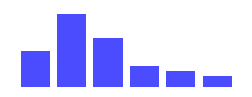

In [16]:
# RUTINA DE MINIGRAFICO
fecha_maxima = df_ventas["Fecha"].max()   # Obtener la fecha máxima
primer_dia_mes_siguiente = (fecha_maxima + pd.offsets.MonthBegin(1)).normalize()   # Truncar al primer día del mes siguiente (evita tener un mes parcial)
primer_dia_6_meses_atras = primer_dia_mes_siguiente - pd.DateOffset(months=6)   # Calcular el primer día 6 meses atrás

# Filtrar el dataframe entre ese rango
df_filtrado = df_ventas[(df_ventas["Fecha"] >= primer_dia_6_meses_atras) &
                        (df_ventas["Fecha"] < primer_dia_mes_siguiente)].copy()
# Agrupar por mes
df_filtrado["Mes"] = df_filtrado["Fecha"].dt.to_period("M").astype(str)
df_mes = df_filtrado.groupby("Mes")["Unidades"].sum().reset_index()

# Crear el gráfico compacto
fig, ax = plt.subplots(figsize=(3, 1))  # Tamaño pequeño para una visualización compacta

# Graficar las barras
ax.bar(range(1, len(df_mes) + 1), df_mes["Unidades"], color=["blue"], alpha=0.7)

# Eliminar ejes y etiquetas para que sea más compacto
ax.set_xticks([])
ax.set_yticks([])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.show()



In [ ]:
# RUTINA RECORRE FORECAST EXCEC con STATUS 30 y pasa a 40

# Filtrar registros con supply_forecast_execution_status_id = 10  #FORECAST OK
for index, row in fe[fe["supply_forecast_execution_status_id"] == 30].iterrows():
    algoritmo = row["name"]
    name = algoritmo.split('_ALGO')[0]
    execution_id = row["id"]
    id_proveedor = row["ext_supplier_code"]
    print("Algoritmo: " + algoritmo + "  - Name: " + name + " exce_id:" + str(execution_id) + " id: Proveedor "+id_proveedor)
    
    try:
        # Llamar a la función que genera los gráficos y datos extendidos
        df_merged = insertar_graficos_forecast(algoritmo, name, id_proveedor)

        # Guardar el archivo CSV
        file_path = f"{folder}/{algoritmo}_Pronostico_Extendido.csv"
        df_merged.to_csv(file_path, index=False)
        print(f"Archivo guardado: {file_path}")

        # Actualizar el status_id a 40 en el DataFrame original
        fe.at[index, "supply_forecast_execution_status_id"] = 40
        # ✅ Actualizar directamente en la base de datos el estado a 40
        update_execution(execution_id, supply_forecast_execution_status_id=40)
        print(f"Estado actualizado a 40 para {execution_id}")

    except Exception as e:
        print(f"Error procesando {name}: {e}")

